In [11]:
import os
import time
import gc
import random
import itertools

from sys import getsizeof

import numpy as np
import pandas as pd
import cv2 as cv
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error

In [12]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [13]:
old_images_path = 'Train'
old_train_path = 'train.csv'
old_test_img_path = 'Test'
old_test_path = 'test.csv'

new_image_path = "new_train"
new_train_path = "new_train.csv"
new_test_img_path = 'new_test'
new_test_path = "new_test.csv"

In [16]:
class Preprocessing:
    def __init__(self, old_images_path, old_csv_path, new_image_path, new_csv_path):
        self.old_images_path = old_images_path
        self.new_image_path = new_image_path
        self.new_csv_path = new_csv_path
        
        self.images = [f'{old_images_path}/{image_path}' for image_path in os.listdir(old_images_path)]
        self.image_nr = 0
        self.df = pd.read_csv(old_csv_path)

    def show_image(self, image):
        cv.imshow('Image', image)
        cv.waitKey(0) 
        cv.destroyAllWindows() 

    def crop_images(self, image):
        image_half = int(image.shape[0]/2)
        topleft_image = image[0:image_half, 0:image_half]
        topright_image = image[0:image_half, image_half-1:-1]
        bottomleft_image = image[image_half-1:-1, 0:image_half]
        bottomright_image = image[image_half-1:-1, image_half-1:-1]
        return (topleft_image, topright_image, bottomleft_image, bottomright_image)
        
    def create_permutations(self, image):
        topleft, topright, bottomleft, bottomright = self.crop_images(image)
        perms = list(itertools.permutations([topleft, topright, bottomleft, bottomright]))
        for permutation in perms:
            top_image = np.concatenate((permutation[0], permutation[1]), axis=1)
            bottom_image = np.concatenate((permutation[2], permutation[3]), axis=1)
            image = np.concatenate((top_image, bottom_image), axis=0)
            image = cv.resize(image, (512, 512))
            cv.imwrite(f'{self.new_image_path}/{self.image_nr}.jpg', image)
            self.image_nr += 1
            
    def get_new_images(self):
        os.mkdir(self.new_image_path)
        for image_path in self.images:
            image = cv.imread(image_path)
            self.create_permutations(image)

        for image_path in self.images:
            image = cv.imread(image_path)
            image = cv.flip(image, 1)
            self.create_permutations(image)

    def get_new_train_csv(self):
        df_duplicates = self.df.reindex(self.df.index.repeat(24)).reset_index(drop=True)

        df_duplicates = pd.concat([df_duplicates, df_duplicates])
        df_duplicates['House ID'] = range(0, len(df_duplicates))
        
        df_duplicates = df_duplicates.reset_index(drop=True)
        df_duplicates.to_csv(self.new_csv_path, index=False)

    def shuffle_images(self):
        numbers = list(range(len(os.listdir(self.new_image_path))))
        random.shuffle(numbers)
        
        df = pd.read_csv(self.new_csv_path)
        df['House ID'] = numbers
        df = df.sort_values('House ID')
        df.to_csv(self.new_csv_path, index=False)
        
        for image_name, new_image_name in zip(list(range(len(os.listdir(self.new_image_path)))), numbers):
            os.rename(f'{self.new_image_path}/{image_name}.jpg', f'{self.new_image_path}/a{new_image_name}.jpg')


In [17]:
pp = Preprocessing(old_images_path, old_train_path, new_image_path, new_train_path)
pp.get_new_images()
pp.get_new_train_csv()
pp.shuffle_images()

In [6]:
class Modelling:
    def __init__(self, train_path, image_path, test_path):
        self.train_data = pd.read_csv(train_path)
        self.test_data = pd.read_csv(test_path) 
        self.image_path = image_path
        self.image_amount = len(os.listdir(image_path))
        
        self.X_train_csv, self.X_val_csv, self.X_train_img, self.X_val_img, self.y_train, self.y_val = None, None, None, None, None, None
        self.X_test = None

        self.checkpoint_path = None
        self.checkpoint = None

        self.models = {'NN': 
                           {'function': self.create_NN, 
                            'model': None,
                            'data': None,
                            'history': pd.DataFrame({'loss': [], 'val_loss': []})},  
                       'CNN': 
                           {'function': self.create_CNN, 
                            'model': None,
                            'data': None,
                            'history': pd.DataFrame({'loss': [], 'val_loss': []})}, 
                       'Transfer': 
                           {'function': self.create_Transfer, 
                            'model': None,
                            'data': None,
                            'history': pd.DataFrame({'loss': [], 'val_loss': []})}, 
                       'MultiModal': 
                           {'function': self.create_MultiModal, 
                            'model': None,
                            'data': None,
                            'history': pd.DataFrame({'loss': [], 'val_loss': []})}}

        self.optimizer = keras.optimizers.Adam(learning_rate=0.001)
        self.early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    
    def prepare_data(self, start, end):
        amount_of_images = end - start
        scaler = StandardScaler() 
        
        X = self.train_data.drop(['Price'], axis=1)
        y = self.train_data['Price']
        
        X_scaled = scaler.fit_transform(X)

        images = np.empty((amount_of_images, 512, 512, 3), dtype=np.uint8)
        for i, image in enumerate(os.listdir(self.image_path)[start:end]):
            image = cv.imread(f'{self.image_path}/{image}')
            images[i, ...] = image

        self.X_train_csv, self.X_val_csv, self.X_train_img, self.X_val_img, self.y_train, self.y_val = \
        train_test_split(X_scaled[start:end], images, y[start:end], test_size=0.2, random_state=42)

        self.models['NN']['data'] = (self.X_train_csv, self.X_val_csv)
        self.models['CNN']['data'] = (self.X_train_img, self.X_val_img)
        self.models['Transfer']['data'] = ([self.X_train_img,  self.X_train_csv], [self.X_val_img, self.X_val_csv])
        self.models['MultiModal']['data'] = ([self.X_train_img,  self.X_train_csv], [self.X_val_img, self.X_val_csv])
        
        #Standariseren 
        self.X_test = scaler.transform(self.test_data)

    def create_NN(self):
        self.models['NN']['model'] = keras.Sequential()

        self.models['NN']['model'].add(layers.Input(shape=(6)))
        self.models['NN']['model'].add(layers.Dense(256, activation='relu', name='NN_dense_1'))
        self.models['NN']['model'].add(layers.Dropout(0.5, name='NN_dropout_1'))
        self.models['NN']['model'].add(layers.Dense(128, activation='relu', name='NN_dense_2'))
        self.models['NN']['model'].add(layers.Dropout(0.3, name='NN_dropout_2'))
        self.models['NN']['model'].add(layers.Dense(64, activation='relu', name='NN_dense_3'))
        self.models['NN']['model'].add(layers.Dense(1, name='NN_dense_output'))
        
        self.models['NN']['model'].compile(optimizer=self.optimizer, loss='mean_absolute_percentage_error')

    def create_CNN(self):
        self.models['CNN']['model'] = keras.Sequential()
        
        self.models['CNN']['model'].add(layers.Input(shape=(512, 512, 3), name='CNN_input_img'))
        self.models['CNN']['model'].add(layers.experimental.preprocessing.Rescaling(1./255, name='CNN_rescaling'))
        self.models['CNN']['model'].add(layers.Conv2D(16, (3, 3), padding='same', activation='relu', name='CNN_conv2d_1'))
        self.models['CNN']['model'].add(layers.MaxPooling2D(name='CNN_max_pooling2d_1'))
        self.models['CNN']['model'].add(layers.Conv2D(32, 3, padding='same', activation='relu', name='CNN_conv2d_2'))
        self.models['CNN']['model'].add(layers.MaxPooling2D(name='CNN_max_pooling2d_2'))
        self.models['CNN']['model'].add(layers.Conv2D(64, 3, padding='same', activation='relu', name='CNN_conv2d_3'))
        self.models['CNN']['model'].add(layers.MaxPooling2D(name='CNN_max_pooling2d_3'))
        self.models['CNN']['model'].add(layers.Flatten(name='CNN_flatten_img'))
        self.models['CNN']['model'].add(layers.Dense(128, activation='relu', name='CNN_dense_combined'))
        self.models['CNN']['model'].add(layers.Dense(1, name='CNN_dense_output'))

        self.models['CNN']['model'].compile(optimizer=self.optimizer, loss='mean_absolute_percentage_error')
        
    def create_Transfer(self):
        pass
        
    def create_MultiModal(self):
        img_input = layers.Input(shape=(512, 512, 3), name='MM_input_img')
        csv_input = layers.Input(shape=(6), name='MM_input_csv')
        
        x_img = layers.experimental.preprocessing.Rescaling(1./255, name='MM_rescaling')(img_input)
        x_img = layers.Conv2D(16, (3, 3), padding='same', activation='relu', name='MM_conv2d_1')(x_img)
        x_img = layers.MaxPooling2D(name='MM_max_pooling2d_1')(x_img)
        x_img = layers.Conv2D(32, 3, padding='same', activation='relu', name='MM_conv2d_2')(x_img)
        x_img = layers.MaxPooling2D(name='MM_max_pooling2d_2')(x_img)
        x_img = layers.Conv2D(64, 3, padding='same', activation='relu', name='MM_conv2d_3')(x_img)
        x_img = layers.MaxPooling2D(name='MM_max_pooling2d_3')(x_img)
        x_img = layers.Flatten(name='MM_flatten_img')(x_img)
        
        x_csv = layers.Flatten(name='MM_flatten_csv')(csv_input)
        x_csv = layers.Dense(16, activation='relu', name='MM_dense_1')(x_csv)
        x_csv = layers.Dense(32, activation='relu', name='MM_dense_2')(x_csv)
        x_csv = layers.Dense(64, activation='relu', name='MM_dense_3')(x_csv)
        
        x = layers.concatenate([x_img, x_csv], name='MM_concatenate')
        x = layers.Dense(128, activation='relu', name='MM_dense_combined')(x)
        output = layers.Dense(1, name='MM_dense_output')(x)
        
        # make model with 2 inputs and 1 output
        self.models['MultiModal']['model'] = tf.keras.models.Model(inputs=[img_input, csv_input], outputs=output)

        self.models['MultiModal']['model'].compile(optimizer=self.optimizer, loss='mean_absolute_percentage_error')
        
    def train_models(self, models, batch_size=1000):  
        for model in models:
            try:
                self.models[model]['function']()
            except:
                print('This model does not exist!')
            
            for i in range(0, 500, batch_size):
                start = i
                end = min(i + batch_size, self.image_amount)
                print(f'Training {model} on images {start} to {end}...')
        
                tf.keras.backend.clear_session()
                
                self.prepare_data(start, end)
                
                self.checkpoint_path = f"{model}_checkpoint.h5"
                self.checkpoint = ModelCheckpoint(self.checkpoint_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
                
                self.models[model]['model'].fit(self.models[model]['data'][0], self.y_train, epochs=50, batch_size=16, \
                                                validation_data=(self.models[model]['data'][1], self.y_val), \
                                                callbacks=[self.early_stopping, self.checkpoint], verbose=0)
                gc.collect()
    
                history = pd.DataFrame(self.models[model]['model'].history.history)
                self.models[model]['history'] = pd.concat([self.models[model]['history'], history], ignore_index=True)
                
    def evaluate_models(self):
        fig, ax = plt.subplots(1, 2)
        for model in self.models.keys():
            plt.tight_layout()
            ax[0].plot(self.models[model]['history']['loss'], label=f'{model} Train Loss')
            ax[0].set_xlabel('Epochs')
            ax[0].set_ylabel('Mean Absolute Percentage Error (mape)')
            ax[0].legend()
            
            ax[1].plot(self.models[model]['history']['val_loss'], label=f'{model} Val Loss')
            ax[1].set_xlabel('Epochs')
            ax[1].set_ylabel('Mean Absolute Percentage Error (mape)')
            ax[1].legend()
            

In [8]:
modelling = Modelling(new_train_path, new_image_path, old_test_path)

In [9]:
modelling.train_models(['NN', 'CNN', 'MultiModal'], batch_size=100)

Training NN on images 0 to 100...

Epoch 1: val_loss improved from inf to 99.99994, saving model to NN_checkpoint.h5

Epoch 2: val_loss improved from 99.99994 to 99.99982, saving model to NN_checkpoint.h5

Epoch 3: val_loss improved from 99.99982 to 99.99964, saving model to NN_checkpoint.h5

Epoch 4: val_loss improved from 99.99964 to 99.99937, saving model to NN_checkpoint.h5

Epoch 5: val_loss improved from 99.99937 to 99.99895, saving model to NN_checkpoint.h5

Epoch 6: val_loss improved from 99.99895 to 99.99829, saving model to NN_checkpoint.h5

Epoch 7: val_loss improved from 99.99829 to 99.99730, saving model to NN_checkpoint.h5

Epoch 8: val_loss improved from 99.99730 to 99.99581, saving model to NN_checkpoint.h5

Epoch 9: val_loss improved from 99.99581 to 99.99358, saving model to NN_checkpoint.h5

Epoch 10: val_loss improved from 99.99358 to 99.99037, saving model to NN_checkpoint.h5

Epoch 11: val_loss improved from 99.99037 to 99.98589, saving model to NN_checkpoint.h5



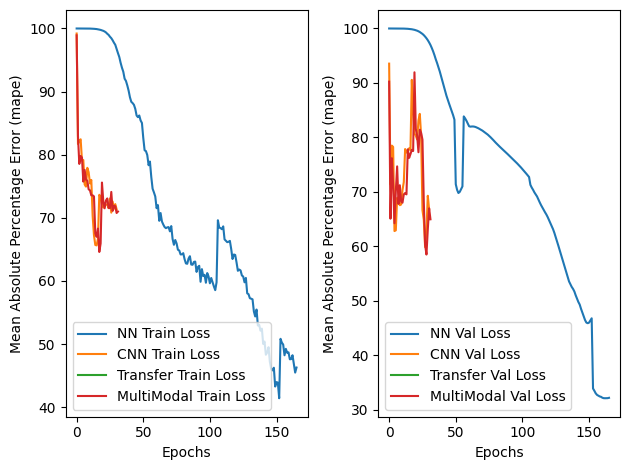

In [10]:
modelling.evaluate_models()